In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.optimize as spopt
import scipy.fftpack as spfft
import scipy.ndimage as spimg
import cvxpy as cvx
from PIL import Image 

(CVXPY) Apr 11 10:41:00 PM: Encountered unexpected exception importing solver GLOP:
RuntimeError('Unrecognized new version of ortools (9.9.3963). Expected < 9.8.0. Please open a feature request on cvxpy to enable support for this version.')
(CVXPY) Apr 11 10:41:00 PM: Encountered unexpected exception importing solver PDLP:
RuntimeError('Unrecognized new version of ortools (9.9.3963). Expected < 9.8.0. Please open a feature request on cvxpy to enable support for this version.')


In [2]:
# Defining code to test metrics
def mse(image1, image2):
    squared_diff = (image1 - image2) ** 2
    mse = squared_diff.mean()
    return mse
def mad(image1, image2):
  diff = image1 - image2
  return np.mean(abs(diff))

In [3]:
# Scipy doesn't have a function for taking the discrete cosine transform on 2D signals so 
# we are constructing our own.
def dct2(x):
    return spfft.dct(spfft.dct(x.T, norm='ortho', axis=0).T, norm='ortho', axis=0)

def idct2(x):
    return spfft.idct(spfft.idct(x.T, norm='ortho', axis=0).T, norm='ortho', axis=0)

In [4]:
X_full = mpl.pyplot.imread('face.jpeg') #loading image
X_full = X_full.mean(axis=2) #changing it to "grayscale"
X = spimg.zoom(X_full, 0.15) #downsizing image
height,width = X.shape #getting height and width of image

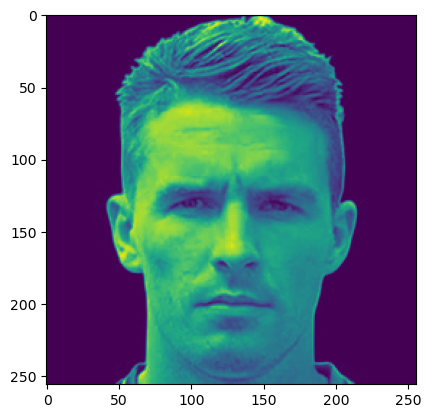

In [5]:
plt.imshow(X_full)

In [6]:
# Extract small sample of signal
k = round(width * height * 0.9) # 90% sample
ri = np.random.choice(width * height, k, replace=False) # random sample of indices
b = X.T.flat[ri]
b = np.expand_dims(b, axis=1)

In [7]:
# Create dct matrix operator using kron (memory errors for large height*width)
A = np.kron(
    spfft.idct(np.identity(width), norm='ortho', axis=0),
    spfft.idct(np.identity(height), norm='ortho', axis=0)
    )

A = A[ri,:] 

# Do L1 optimization
vx = cvx.Variable(width * height)
objective = cvx.Minimize(cvx.norm(vx, 1))
constraints = [A*vx == b.flatten()]  # Flatten b to make it 1D
prob = cvx.Problem(objective, constraints)
result = prob.solve(verbose=True)
Xat2 = np.array(vx.value).squeeze()


                                     CVXPY                                     
                                     v1.4.2                                    
(CVXPY) Apr 11 10:41:00 PM: Your problem has 1444 variables, 1 constraints, and 0 parameters.
(CVXPY) Apr 11 10:41:00 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Apr 11 10:41:00 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Apr 11 10:41:00 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Apr 11 10:41:00 PM: Your problem is compiled with the CPP canonicalization backend.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Apr 11 10:41:00 PM: Compiling problem (target solver=ECOS).
(C

/Users/Divya/anaconda3/lib/python3.11/site-packages/cvxpy/expressions/expression.py:621: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 1 times so far.

  warnings.warn(msg, UserWarning)
/Users/Divya/anaconda3/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)


(CVXPY) Apr 11 10:41:01 PM: Applying reduction ECOS
(CVXPY) Apr 11 10:41:01 PM: Finished problem compilation (took 5.379e-01 seconds).
-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
(CVXPY) Apr 11 10:41:01 PM: Invoking solver ECOS  to obtain a solution.

ECOS 2.0.4 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +3e+06  1e+00  1e-02  1e+00  1e+03    ---    ---    1  1  - |  -  - 
 1  +6.673e+03  +6.799e+03  +8e+05  8e-01  3e-03  1e+02  3e+02  0.8684  1e-01   1  0  1 |  0  0
 2  +1.428e+04  +1.430e+04  +1e+05  3e-01  4e-04  2e+01  4e+01  0.8757  2e-02   1  0  0 |  0  0
 3  +2.994e+04  +2.995e+04  +2e+04  7e-02  8e-05  5e+00  8e+00  0.8310  4e-02  

In [8]:
result

40455.18563537822

In [9]:
# reconstruct signal
Xat = Xat2.reshape(width, height).T # stack columns
Xa = idct2(Xat)

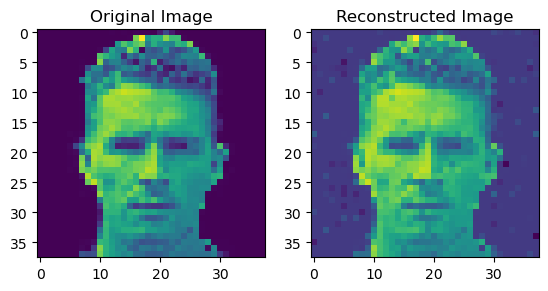

In [10]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 3, 1)
plt.imshow(X)
plt.title('Original Image')

plt.subplot(1, 3, 2)
plt.imshow(Xa)
plt.title('Reconstructed Image')

plt.show()

In [11]:
norm_orig = X/255
norm_result = Xa/255
print(mse(norm_orig, norm_result))
print(mse(X,Xa))
print(mad(X,Xa))

0.000958276271376117
62.311914546232
1.9188619260703264
